In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import imutils
import cv2
import os

In [3]:
#initialize the list of data and labels
data = []
labels = []

#loop over the input images
for imagePath in sorted(list(paths.list_images('smiles'))):
    #load the image and preprocess it
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width = 28)
    image = img_to_array(image)
    data.append(image)
    
    #extract the class labels and update label list
    label = imagePath.split(os.path.sep)[-2]
    label = 'not_smiling' if label == 'negatives' else 'smiling'
    labels.append(label)

In [4]:
#scale the raw pixel intensities to range [0, 1]
data = np.array(data, dtype = 'float')/255.0
labels = np.array(labels)

#convert labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 2)

In [5]:
#handling class imbalance
classTotals = labels.sum(axis = 0)
print(classTotals)
classWeight = classTotals.max()/classTotals
print(classWeight)

[9475. 3690.]
[1.        2.5677507]


In [6]:
#splitting the data into training and testing set
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2,
                                                 stratify = labels, random_state = 42)

In [7]:
classes = 2
inputShape = (28, 28, 1)

def model():
    model = Sequential()
    
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    return model

In [8]:
model = model()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________

In [9]:
H = model.fit(trainX, trainY, validation_data = (testX, testY), class_weight = classWeight,
batch_size = 64, epochs = 15, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 4s 350us/sample - loss: 0.4278 - acc: 0.8041 - val_loss: 0.3540 - val_acc: 0.8397
Epoch 2/15
10532/10532 [==============================] - 1s 90us/sample - loss: 0.2732 - acc: 0.8903 - val_loss: 0.2657 - val_acc: 0.8959
Epoch 3/15
10532/10532 [==============================] - 1s 89us/sample - loss: 0.2509 - acc: 0.9031 - val_loss: 0.2493 - val_acc: 0.9013
Epoch 4/15
10532/10532 [==============================] - 1s 91us/sample - loss: 0.2307 - acc: 0.9072 - val_loss: 0.2711 - val_acc: 0.8918
Epoch 5/15
10532/10532 [==============================] - 1s 89us/sample - loss: 0.2158 - acc: 0.9168 - val_loss: 0.2484 - val_acc: 0.9009
Epoch 6/15
10532/10532 [==============================] - 1s 89us/sample - loss: 0.2071 - acc: 0.9202 - val_loss: 0.2344 - val_acc: 0.9077
Epoch 7/15
10532/10532

In [10]:
#saving model
model.save('lenet.hdf5')

In [11]:
#evaluating the network
predictions = model.predict(testX, batch_size = 64)
print(classification_report(testY.argmax(axis = 1), predictions.argmax(axis = 1),
                           target_names = le.classes_))

              precision    recall  f1-score   support

 not_smiling       0.93      0.96      0.94      1895
     smiling       0.88      0.81      0.84       738

    accuracy                           0.91      2633
   macro avg       0.90      0.88      0.89      2633
weighted avg       0.91      0.91      0.91      2633



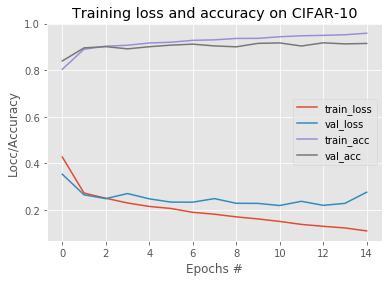

In [13]:
#plotting the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, 15), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, 15), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, 15), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, 15), H.history['val_acc'], label = 'val_acc')
plt.title('Training loss and accuracy on CIFAR-10')
plt.xlabel('Epochs #')
plt.ylabel('Locc/Accuracy')
plt.legend()
plt.show()

In [14]:
#detect smile
from tensorflow.keras.models import load_model


In [ ]:
#load face detector cascade and smile detector CNN
detector = cv2.CascadeClassifier('haarcascade.xml')
model = load_model('lenet.hdf5')

#if video path was supplied
#camera = cv2.VideoCapture(0)

#otherwise load video
camera = cv2.VideoCapture('video5.mp4')


#keep looping
while True:
    #grab the current frame
    (grabbed, frame) = camera.read()

    #if video ended
    if grabbed== 0:
        break

    #resize frame, convert it to grayscale and clone the original frame so
    #we can draw on it later
    frame = imutils.resize(frame, width = 300)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameClone = frame.copy()

    #detect the faces in input frame and clone the frame so we can draw on it later
    rects = detector.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5, minSize = (30, 30),
                                      flags = cv2.CASCADE_SCALE_IMAGE)


    #loop over the face bounding boxes
    for (fX, fY, fW, fH) in rects:
        #extract the ROI of face from grayscale image, resize it to a fixed 28x28 pixcels
        #then prepare ROI for classification
        roi = gray [fY:fY +fH, fX:fX + fW]
        roi = cv2.resize(roi, (28, 28))
        roi = roi.astype('float')/255.0
        roi = img_to_array(roi)
        roi = np.expand_dims (roi, axis = 0)

        #determin the probability of both smiling and notq smiling
        (notSmiling, smiling) = model.predict(roi)[0]
        label = 'Smiling' if smiling > notSmiling else 'Not Smiling'


        #display the label and bounding box rectangle on output frame
        cv2.putText(frameClone, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH), (0, 0, 255), 2)


        #show our detected faces along with labels
        cv2.imshow('Face', frameClone)


        #if q is pressed stop loop
        if cv2.waitKey(0) & 0xFF == ord('q'):
            break

    #cleanup camera and close open windows
    camera.release()
    cv2.destroyAllWindows()